# Fit Spikes of HH with AdEx

In [1]:
from brian2 import *
from brian2modelfitting import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(2000*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.16s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


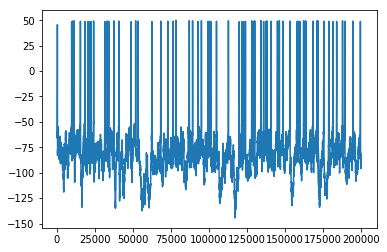

In [7]:
voltage = mon.v[0]/mV
plot(voltage);

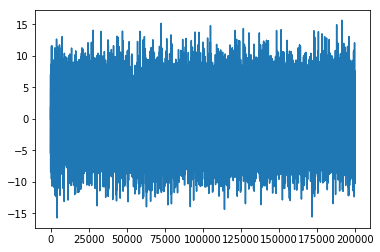

In [8]:
inp_cur = mon.I[0]/nA
plot(inp_cur);

In [9]:
out_spikes = [spike_mon.spike_trains()[0]/ms]
out_spikes

[array([   2.73,   96.6 ,  102.26,  111.96,  154.17,  183.23,  203.35,
         214.67,  224.65,  241.08,  314.93,  330.63,  340.24,  373.97,
         407.32,  486.74,  517.14,  533.91,  623.89,  682.32,  728.74,
         763.56,  782.22,  869.67,  891.29,  926.71,  949.28,  992.32,
        1003.72, 1010.83, 1048.31, 1126.66, 1197.88, 1214.84, 1226.37,
        1238.59, 1279.92, 1290.28, 1299.57, 1339.77, 1358.05, 1373.13,
        1380.7 , 1407.53, 1448.94, 1461.31, 1485.71, 1531.09, 1576.76,
        1583.42, 1596.32, 1620.73, 1633.3 , 1637.95, 1683.73, 1708.12,
        1713.94, 1753.18, 1786.25, 1814.12, 1838.07, 1876.59, 1891.34,
        1945.19, 1993.91])]

## AdEx

In [11]:
start_scope()

In [12]:
# Parameters
C = 171 * pF
# gL = 60 * nS
gL = 6.16243899e-08*siemens
taum = C / gL
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV
Vcut = VT + 50 * DeltaT

In [13]:
taum

2.77487534 * msecond

In [14]:
# Pick an electrophysiological behaviour
tauw, a, b, Vr = 124*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)


In [15]:
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
"""

In [16]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spike_mon = SpikeMonitor(neuron)

In [19]:
# run(30*ms)

## Model Fitting

In [30]:
eqs = Equations(
"""
taum = C / gL : second
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
gL: siemens (constant)
a : siemens (constant)
b : amp (constant)
VT : volt (constant)
DeltaT : volt (constant)
Vr : volt (constant)
""", 
# EL : volt (constant)
# C: farad (constant)
# gL = 60 * nS,
# VT = -50.4 * mV,
# DeltaT = 5 * mV,    
# a = 4*nS,
# b = 0.0805*nA,
# Vr = -70.6*mV
EL = -65 * mV,
C = 171 * pF,
tauw = 144*ms,
)

In [38]:
n_opt = NevergradOptimizer()
metric = GammaFactor(300*ms)

In [39]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                         input=[inp_cur] * nA, output=out_spikes,
                     n_samples=30,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     param_init={'v': -65*mV},
                     )

In [40]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[20*nS, 100*nS],
                                a = [0, 20]*nS,
                                b = [0, 10]*nA,
                                VT = [-80, -20] * mV,
                                DeltaT = [0.1, 10] * mV,    
                                Vr = [-80, -40]*mV
                               )

Round 0: fit (4.1467392387328654e-08, -0.07269697871253897, 0.007713170398302998, 1.3258743070420083e-08, -0.04378549227040585, 3.4593819659403725e-09) with error: 0.8112842509522158
Round 1: fit (3.466878659417955e-08, -0.07483618213450594, 0.007113677642552742, 1.4227135597918406e-08, -0.03201223991789623, 8.167572612025456e-09) with error: 0.8017626941315221
Round 2: fit (3.466878659417955e-08, -0.07483618213450594, 0.007113677642552742, 1.4227135597918406e-08, -0.03201223991789623, 8.167572612025456e-09) with error: 0.8017626941315221
Round 3: fit (3.466878659417955e-08, -0.07483618213450594, 0.007113677642552742, 1.4227135597918406e-08, -0.03201223991789623, 8.167572612025456e-09) with error: 0.8017626941315221
Round 4: fit (3.466878659417955e-08, -0.07483618213450594, 0.007113677642552742, 1.4227135597918406e-08, -0.03201223991789623, 8.167572612025456e-09) with error: 0.8017626941315221
Round 5: fit (3.466878659417955e-08, -0.07483618213450594, 0.007113677642552742, 1.4227135597

In [41]:
# print('goal:', {'gL': 30*nS, 'C':1*nF})
# print('results:', result_dict['C']*farad, result_dict['gL']*siemens)

In [42]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

spike times: [array([   3.36,    8.37,   48.47,   56.25,   79.81,   93.88,  100.19,
        102.03,  103.14,  106.42,  111.35,  113.27,  122.49,  150.45,
        173.79,  179.81,  193.6 ,  201.46,  204.31,  208.75,  214.32,
        222.71,  235.5 ,  251.49,  281.15,  312.74,  314.27,  320.79,
        330.52,  338.31,  348.21,  351.22,  371.5 ,  373.94,  376.08,
        389.59,  394.03,  405.05,  427.82,  453.79,  474.86,  486.44,
        498.96,  505.68,  516.89,  519.28,  533.08,  533.81,  535.07,
        588.  ,  616.68,  621.15,  622.54,  662.12,  677.46,  681.9 ,
        699.83,  703.76,  716.31,  726.88,  731.01,  749.46,  761.71,
        763.46,  770.76,  781.71,  782.36,  788.02,  814.04,  828.  ,
        862.14,  868.89,  873.51,  889.28,  891.66,  895.43,  917.46,
        925.04,  933.45,  948.84,  950.71,  972.09,  975.7 ,  989.89,
        994.07, 1000.84, 1004.97, 1006.59, 1010.6 , 1031.44, 1046.87,
       1048.22, 1051.17, 1088.77, 1125.82, 1126.95, 1159.09, 1194.41,
      

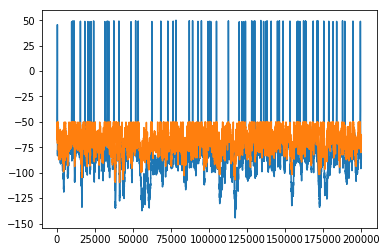

In [43]:
fits = fitter.generate(params=None, output_var='v',)

# Vizualize the resutls
plot(voltage);
plot(fits[0]/mV)
plt.show()

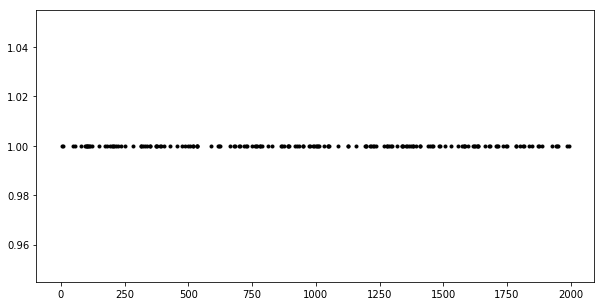

In [56]:
plt.figure(figsize=(10,5))

plot(spikes, np.ones_like(spikes), '.k');

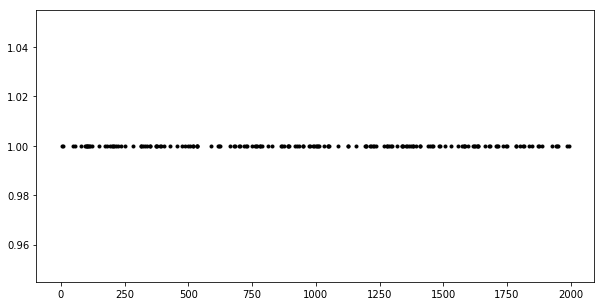

In [73]:
plt.figure(figsize=(10,5))

plot(spikes, np.ones_like(spikes), '.k');

In [62]:
out_spikes

[array([   2.73,   96.6 ,  102.26,  111.96,  154.17,  183.23,  203.35,
         214.67,  224.65,  241.08,  314.93,  330.63,  340.24,  373.97,
         407.32,  486.74,  517.14,  533.91,  623.89,  682.32,  728.74,
         763.56,  782.22,  869.67,  891.29,  926.71,  949.28,  992.32,
        1003.72, 1010.83, 1048.31, 1126.66, 1197.88, 1214.84, 1226.37,
        1238.59, 1279.92, 1290.28, 1299.57, 1339.77, 1358.05, 1373.13,
        1380.7 , 1407.53, 1448.94, 1461.31, 1485.71, 1531.09, 1576.76,
        1583.42, 1596.32, 1620.73, 1633.3 , 1637.95, 1683.73, 1708.12,
        1713.94, 1753.18, 1786.25, 1814.12, 1838.07, 1876.59, 1891.34,
        1945.19, 1993.91])]

In [80]:
rcParams["scatter.marker"] = "|"

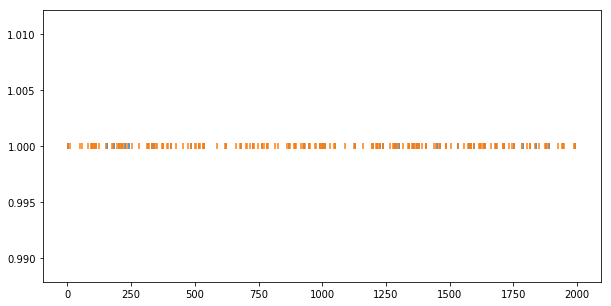

In [82]:
plt.figure(figsize=(10,5))
scatter(out_spikes[0], np.ones_like(out_spikes[0]));
scatter(spikes[0], np.ones_like(spikes[0]));

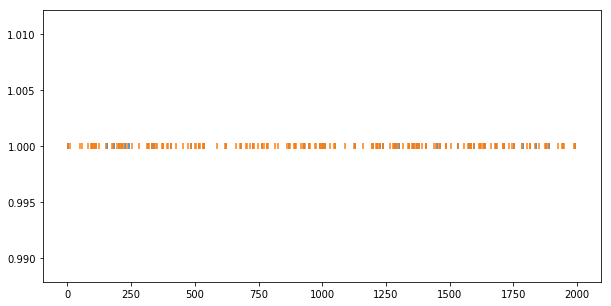

In [85]:
plt.figure(figsize=(10,5))

scatter(out_spikes[0], np.ones_like(out_spikes[0]));
scatter(spikes[0], np.ones_like(spikes[0]));

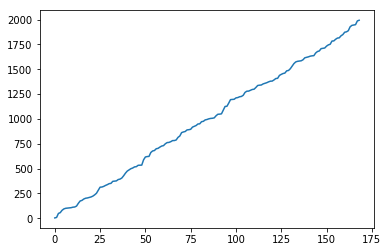

In [68]:
plot(spikes[0])